In [1]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
from peakdetect import peakdetect
from scipy.ndimage.interpolation import shift
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.optimize import newton
%matplotlib inline

In [2]:
engine = create_engine('sqlite+pysqlite:///../SQL/72_8b.db')

In [3]:
import time
start_time = time.time()
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
Hitdf = pd.io.sql.read_sql("SELECT * FROM Hit", engine)
PSAdf = pd.io.sql.read_sql("SELECT * FROM PSA", engine)
ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
RawADCdf = pd.io.sql.read_sql("SELECT * FROM RawADC", engine)
end_time = time.time()
print end_time-start_time

349.172574043


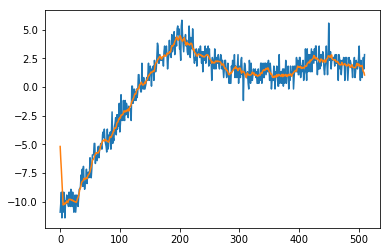

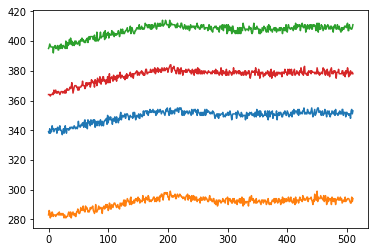

In [39]:
tmp = RawADCdf[(RawADCdf['PadNum']==-1)&(RawADCdf['EventID']==0)].iloc[:,4:].values
tmp1 = tmp-tmp.mean(axis=1)[:,None]
plt.plot(tmp1.mean(axis=0))
base = np.convolve(tmp1.mean(axis=0),([1]*10)[::-1],'same')/10
plt.plot(base)
plt.figure()
plt.plot(tmp.T);
#plt.plot((tmp-tmp.mean(axis=1)[:,None]).T,c=(1,0,0,0.2));

In [43]:
def Process(Event):
    Event = Event[Event['PadNum']<0]
    tmp = Event.iloc[:,4:].values
    print Event
    #tmp1 = tmp-tmp.mean(axis=1)[:,None]
    #base = np.convolve(Event.mean(axis=0),([1]*10)[::-1],'same')/10
    return base
start_time = time.time()
Base_df = RawADCdf[:100].groupby('EventID').apply(Process)
end_time = time.time()
print end_time-start_time
print Base_df.head()

    ID  EventID  PadNum   t0   t1   t2   t3   t4   t5   t6  ...   t502  t503  \
1    2        0      -1  322  339  338  341  338  340  339  ...    351   351   
2    3        0      -2  385  400  400  401  402  402  404  ...    411   412   
3    4        0      -3  394  412  413  411  412  410  411  ...    421   419   
69  70        0      -1  270  283  286  285  281  284  282  ...    294   294   
70  71        0      -2  326  339  340  340  339  341  339  ...    350   349   
71  72        0      -3  289  301  300  302  300  305  303  ...    315   311   

    t504  t505  t506  t507  t508  t509  t510  t511  
1    350   351   351   348   353   354   351   353  
2    413   414   411   413   411   411   411   413  
3    419   418   421   423   420   422   421   421  
69   294   293   292   291   291   295   292   294  
70   350   349   346   350   348   350   348   351  
71   313   312   313   312   314   314   313   314  

[6 rows x 515 columns]
    ID  EventID  PadNum   t0   t1   t2   t3 

In [5]:
def convolve(event):
    mesh_convol = np.convolve(event.values,([1]*10)[::-1],'same')
    return pd.Series(mesh_convol,index=['t'+str(i) for i in range(512)])
convol_df=mesh_df.apply(convolve,axis=1)
convol_df.reset_index(inplace=True)

In [6]:
status_df = pd.read_csv("72_8_t0.csv")
status_df.columns = ['EventID','trigger']

In [7]:
convol_df.head()

,EventID,t0,t1,t2,t3,t4,t5,t6,t7,t8,...,t502,t503,t504,t505,t506,t507,t508,t509,t510,t511
0,0,45.6,45.6,45.6,45.6,45.6,45.6,0.0,0.0,0.0,...,2676.999996,2654.199997,2620.399998,2593.599998,2569.799999,2561.799999,2277.000000,2027.000000,1785.000000,1528.000000
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1170.999969,1188.999969,1188.999969,1193.999969,1198.999969,1203.999969,1080.799973,959.599976,844.399979,718.199982
2,2,45.4,45.4,45.4,45.4,45.4,45.4,0.0,0.0,0.0,...,1853.000000,1848.000000,1839.000000,1849.000000,1855.000000,1839.000000,1653.000000,1469.000000,1281.000000,1090.000000
3,3,56.1,56.1,56.1,56.1,56.1,56.1,0.0,0.0,0.0,...,1780.999977,1783.999977,1776.999977,1773.999977,1771.999977,1764.999977,1592.599979,1412.199982,1238.799984,1056.399986
4,4,74.6,74.6,74.6,74.6,74.6,74.6,0.0,0.0,0.0,...,2560.400013,2524.800013,2492.200012,2464.600012,2466.600012,2453.600012,2172.700012,1925.400013,1689.100010,1451.800007


something is wrong 491
something is wrong 1147
something is wrong 1221
something is wrong 1347
something is wrong 1403
something is wrong 1502
something is wrong 1606


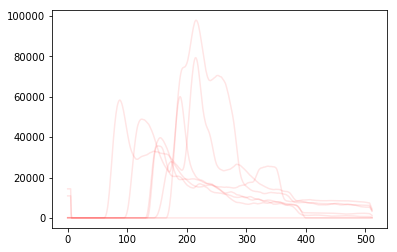

In [8]:
def TriggerFinder(r):
    try:
        trig = status_df.ix[r['EventID']]['trigger']
        thre = 7000
        width = 20
        s,e = int(trig-width),int(trig+width)
        func = interp1d(range(s,e), r.iloc[s+1:e+1].values-thre, kind='cubic')
        return newton(func,trig)
    except:
        print "something is wrong",int(r['EventID'])
        plt.plot(r.iloc[1:].values,c=(1,0,0,0.1))
        #return np.nan
    #plt.figure()
    #plt.plot(range(s,e),r.iloc[int(trig-width+1):int(trig+width+1)].values,c='r')
    #plt.plot(range(s,e),func(range(s,e)),c='b')
    
mask = (status_df['trigger']>350)&(status_df['trigger']<400)
    
Trigger_df = convol_df[mask].iloc[:].apply(TriggerFinder,axis=1)

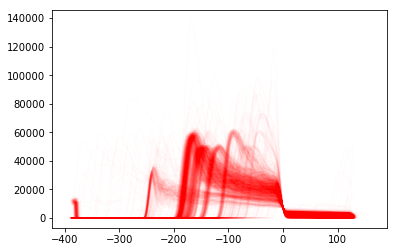

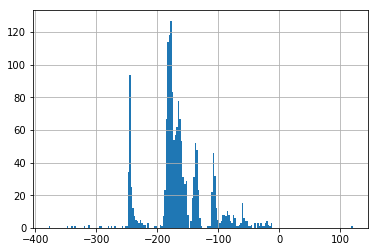

In [9]:
%matplotlib inline
def Process(r):
    x = np.arange(512) - Trigger_df.ix[r['EventID']]
    y = r.iloc[1:].values
    
    grad = np.gradient(y)
    ax = np.argmax(grad)
    plt.plot(x,y, c=(1,0,0,0.01))
    return x[ax]
    #plt.plot(x,y, c=(1,0,0,0.1))

Time_df = convol_df.ix[Trigger_df[~(Trigger_df.isnull())].index].apply(Process,axis=1);
plt.figure()
Time_df.hist(bins=200)
#plt.xlim(-10,10)
#plt.ylim(-10,10000)

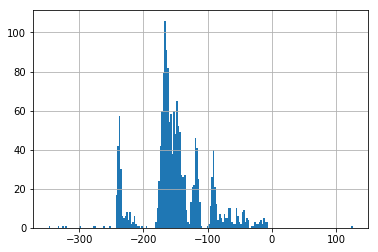

In [10]:
%matplotlib inline
def Process(r):
    x = np.arange(512) - Trigger_df.ix[r['EventID']]
    y = r.iloc[1:].values
    
    ax = np.argmax(y)
    
    return x[ax]
    #plt.plot(x,y, c=(1,0,0,0.1))

Time1_df = convol_df.ix[Trigger_df[~(Trigger_df.isnull())].index].apply(Process,axis=1);
Time1_df.hist(bins=200)

<IPython.core.display.Javascript object>


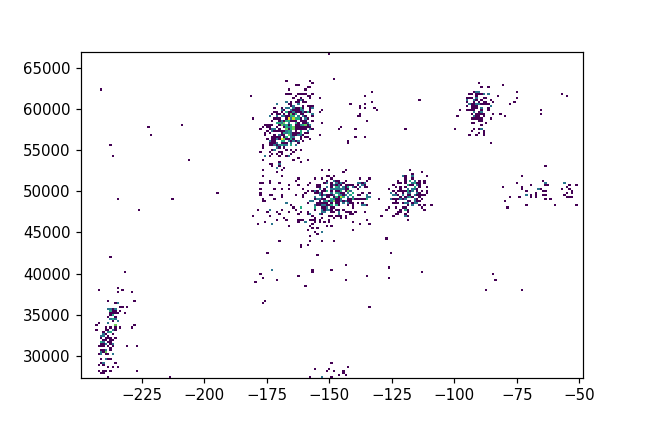

In [74]:
%matplotlib notebook
Heights_df = convol_df.ix[Trigger_df[~(Trigger_df.isnull())].index].max(axis=1)
plt.hist2d(Time_df.values,Heights_df.values,bins=500,norm=LogNorm());
#plt.xlim([-200,-100])
#plt.ylim([40000,70000])
#plt.figure()
#plt.hist2d(Time1_df.values,Heights_df.values,bins=500,norm=LogNorm());

[[-2506.  -2465.  -2461.  ...,   -31.    -40.    -50. ]
 [-2340.4 -2263.4 -2527.4 ...,  -138.4  -230.4   -67.4]
 [-2566.3 -2461.3 -2456.3 ...,   180.7   204.7   129.7]]
[[89684 89725 89729 ..., 92159 92150 92140]
 [89869 89946 89682 ..., 92071 91979 92142]
 [89870 89975 89980 ..., 92617 92641 92566]
 ..., 
 [90437 90483 90476 ..., 93881 93776 93786]
 [89914 89879 89803 ..., 92940 92986 92960]
 [90482 90436 90245 ..., 93568 93507 93775]]


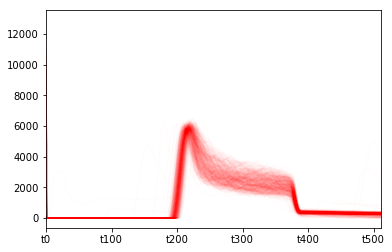

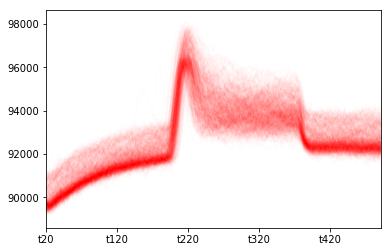

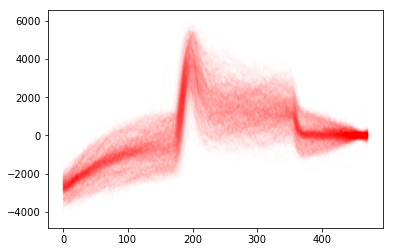

In [12]:
mask =(Heights_df>54000)&(Heights_df<65000)&(Time_df>-200)&(Time_df<-160)
mesh_df.ix[Time_df[mask].index].T.plot(c=(1,0,0,0.01),legend=None)
plt.figure()
tmp = Rawmesh_df.ix[Time_df[mask].index].iloc[:,20:-20]
tmp.T.plot(c=(1,0,0,0.01),legend=None)
plt.figure()
plt.plot((tmp.values- tmp.iloc[:,-20:].mean(axis=1).values[:,None]).T,c=(1,0,0,0.01));
print (tmp.values- tmp.iloc[:,-20:].mean(axis=1).values[:,None])[:3]
print tmp.values

In [18]:
Rawmesh_df

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t502,t503,t504,t505,t506,t507,t508,t509,t510,t511
EventID,,,,,,,,,,,,,,,,,,,,,
0,84947,89540,89521,89428,89364,89365,89374,89468,89382,89446,...,92285,92160,92211,92315,92493,92412,92344,92151,93225,92880
1,83870,90771,90744,90789,90826,90809,90937,90920,91017,90860,...,93373,93426,93387,93385,93662,93361,93397,93217,94389,94289
2,83937,89967,90159,90172,90202,90345,90293,90279,90367,90364,...,92725,92696,92742,92768,92778,92724,92776,92896,93637,93703
3,84562,89037,89270,89506,89510,89485,89355,89290,89337,89323,...,92107,92232,92142,92226,92011,92016,92143,92196,93059,92713
4,83730,89552,89503,89534,89552,89758,89631,89598,89635,89561,...,92046,92127,91914,92458,92183,92258,92228,92176,93087,92947
5,83828,89405,89504,89555,89669,89611,89573,89448,89560,89691,...,91938,92091,92430,92296,91999,92085,91957,91810,92755,92785
6,84816,89581,89683,89617,90029,89930,89974,89841,89783,90036,...,92672,92575,92631,92766,92678,92715,92841,93021,93792,93146
7,84740,89319,89312,89465,89481,89457,89403,89441,89548,89678,...,92046,92151,92238,92173,92059,92067,92182,92120,93070,92677
8,85141,89832,89758,89788,89555,89596,89786,90041,89958,89918,...,92438,92405,92247,92263,92337,92466,92471,92398,93303,93001


<IPython.core.display.Javascript object>


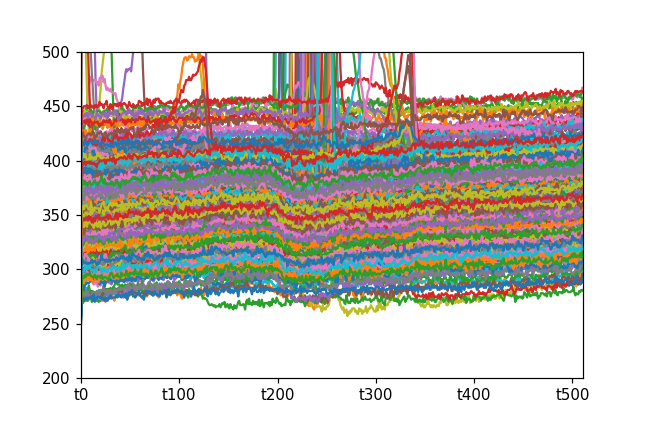

(200, 500)

In [77]:
RawADCdf[RawADCdf["EventID"]==0].iloc[:,3:].T.plot(legend=None);
#plt.xlim([0,200])
plt.ylim([200,500])

[ 40  46  65 106  57] [ 17.82659056  23.42613193  29.02567331  32.75870089  46.75755433]
[40] [17.826590556156688]


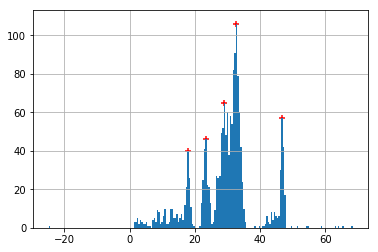

In [68]:
Time_df = convol_df.ix[Trigger_df[~(Trigger_df.isnull())].index].apply(Process,axis=1);
plt.figure()
TW = 80 ##ns
Drift_Speed = 2.459 ##cm/us
#Drift_Speed = 2.648 ##cm/us

(Time_df*(-TW*Drift_Speed*0.001)).hist(bins=200)
bins,edges = np.histogram(-Time_df*(TW*Drift_Speed*0.001),bins=200)
import peakutils
index = peakutils.indexes(bins, thres=0.1, min_dist=5)
print bins[index],(edges[index]+edges[index+1])/2.0
print [bins[index[0]]],[(edges[index[0]]+edges[index[0]+1])/2.0]
plt.scatter((edges[index]+edges[index+1])/2.0,bins[index],marker='+',c='r')

In [40]:
bins.shape

(201,)